In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import xarray as xr

# Extrapolation in temperature

In [2]:
#Import idealgas module
from thermoextrap.xtrapy import idealgas

#Define test betas and reference beta
betas = np.arange(0.1, 10.0, 0.5)
beta_ref = betas[11]
vol = 1.0

#Define orders to extrapolate to
orders = [1,2,4,6]
order = orders[-1]

npart = 1000 #Number of particles (in single configuration)
nconfig = 100_000 #Number of configurations

#Generate all the data we could want
xdata, udata = idealgas.generate_data((nconfig, npart), beta_ref, vol)

## Case 2: Observable is an average with explicit temperature dependence

This is a more difficult case because the derivatives are more complicated. However, this case has also been coded in the library. Extra data will need to be provided, but then everything is handled by flags in the code for creating the data and models. The catch is that we cannot foresee every way that an observable may depend on the extrapolation variable. But if the derivatives of the observable being averaged with respect to the extrapolation variable are known up to the desired order, we can incorporate these into our computation of extrapolation and interpolation coefficients. That means these must also be provided with the input data.

For our averaged quantity that depends explicitly on temperature, we select the average dimensionless potential energy of a single ideal gas particle, $\beta u = \langle \beta a x \rangle = \langle \beta x \rangle$ where $a=1$ for simplicity. The average is over all particles and configurations. 

Everything can be set up in pretty much the same way as Case 1. EXCEPT that we now have to provide not only data for the observable, but also its derivatives in $\beta$. The derivatives must be supplied up to the desired maximum order. This is a bit cumbersome in general, but hopefully your explicit dependence is polynomial (as it is here) or exponential in $\beta$. In these cases, derivatives of arbitrarily high order are trival to compute. 

So now the observable data can have 3 dimensions - for each configurational snapshot, for each derivative order starting at zero (i.e., the observable value) and going to the maximum desired, and for each element in the observable array. Note that the second dimension represents the derivatives of the observable with respect to the extrapolation variable. So for the first derivative, this is just $x$ in this example and for all subsequent derivatives up to the desired order, we pad with zeros.

In [3]:
# You can use numpy and just wrap with xarray after...
xdataDepend = np.array([xdata*beta_ref, xdata])
xdataDepend = np.vstack((xdataDepend, np.zeros((orders[-1] - 1, xdata.shape[0]))))
xdata = xr.DataArray(xdata, dims=['rec'])
udata = xr.DataArray(udata, dims=['rec'])
#Note the naming of dimensions here and see "Data_Organization" for a full explanation
xdataDepend = xr.DataArray(xdataDepend, dims=['deriv', 'rec'], coords={'deriv':np.arange(xdataDepend.shape[0])})
print(xdataDepend)

# # Or you can accomplish this with xarray if you really want to...
# xdata = xr.DataArray(xdata, dims=['rec'])
# udata = xr.DataArray(udata, dims=['rec'])
# xdataDepend = (
#     xr.concat([xdata*beta_ref, xdata], dim='deriv')
#     .assign_coords(deriv=lambda x: np.arange(x.sizes['deriv']))
#     .reindex(deriv=np.arange(orders[-1] + 1))
#     .fillna(0.0)
# )
# print(xdataDepend)

<xarray.DataArray (deriv: 7, rec: 100000)>
array([[1.00684781, 1.0037247 , 0.90726494, ..., 0.98644105, 0.95948982,
        0.97645305],
       [0.17979425, 0.17923655, 0.1620116 , ..., 0.17615019, 0.17133747,
        0.17436662],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])
Coordinates:
  * deriv    (deriv) int64 0 1 2 3 4 5 6
Dimensions without coordinates: rec


In [4]:
import thermoextrap.xtrapy.xpan_beta as xpan_beta

In [5]:
# Create the model and data, here with the data object just created inside the call for the model
# The data is always accessible directly as model.data
order = orders[-1]
xem_dep = xpan_beta.factory_extrapmodel(
    beta=beta_ref, 
    data=xpan_beta.DataCentralMomentsVals.from_vals(
        uv=udata,
        xv=xdataDepend, 
        # by specifying deriv dimension, trigger doing coef calculation with explicit derivatives
        deriv_dim='deriv',
        order=orders[-1],
        central=True)
)

In [6]:
#Check the parameters
print("Model parameters (derivatives):")
print(xem_dep.xcoefs(norm=False))
print('\n')

#Finally, look at predictions
print("Model predictions:")
print(xem_dep.predict(betas[:4], order=2))
print('\n')

Model parameters (derivatives):
<xarray.DataArray (order: 7)>
array([ 9.79183665e-01,  1.64386490e-02, -2.41303266e-02,  9.68283545e-02,
       -2.23986998e-01,  1.83017427e+00, -2.85189760e+02])
Dimensions without coordinates: order


Model predictions:
<xarray.DataArray (beta: 4)>
array([0.52379991, 0.59536134, 0.66089019, 0.72038646])
Coordinates:
  * beta     (beta) float64 0.1 0.6 1.1 1.6
    dalpha   (beta) float64 -5.5 -5.0 -4.5 -4.0
    beta0    float64 5.6




In [7]:
#And bootstrapped uncertainties
print("Bootstrapped uncertainties in predictions:")
print(xem_dep.resample(nrep=100, parallel=True).predict(betas[:4], order=2).std('rep'))

Bootstrapped uncertainties in predictions:
<xarray.DataArray (beta: 4)>
array([0.08415118, 0.06958095, 0.05639604, 0.04459646])
Coordinates:
  * beta     (beta) float64 0.1 0.6 1.1 1.6
    dalpha   (beta) float64 -5.5 -5.0 -4.5 -4.0
    beta0    float64 5.6


True extrapolation coefficients: [ 9.79215103e-01  1.71504528e-02 -1.35661750e-02  1.00692980e-02
 -6.72191329e-03  3.62437174e-03 -9.32132566e-04]
	 With N_configs =     10: [ 9.85079507e-01  6.62805849e-02 -4.08556240e-02  2.91047226e+00
  1.25922339e+00 -3.54628885e+02 -1.01259918e+02]
	 With N_configs =    100: [ 9.79747226e-01  3.59891702e-02  5.60344837e-02 -1.61071684e+00
  2.66999883e+01 -2.40987252e+01 -3.43188795e+03]
	 With N_configs =   1000: [ 9.79066448e-01  1.31205552e-02 -1.23406423e-01  5.55544630e-01
  5.20137652e+00  3.58570126e+01 -5.09462310e+02]
	 With N_configs =  10000: [ 9.79005009e-01  1.66935649e-02 -2.40874636e-02  4.64347857e-01
  1.35878238e+00 -9.57917797e+00 -3.11859282e+02]
	 With N_configs = 100000: [ 9.79183665e-01  1.64386490e-02 -2.41303266e-02  9.68283545e-02
 -2.23986998e-01  1.83017427e+00 -2.85189760e+02]


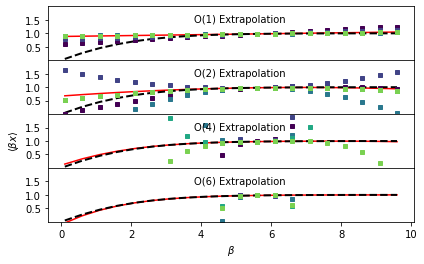

In [8]:
fig, ax = plt.subplots(len(orders), sharex=True, sharey=True)

nsampvals = np.array((10.0*np.ones(5))**np.arange(1,6), dtype=int)
nsampcolors = plt.cm.viridis(np.arange(0.0, 1.0, float(1.0/len(nsampvals))))

#First plot the analytical result
for a in ax:
    a.plot(betas, betas*idealgas.x_ave(betas, vol), 'k--', linewidth=2.0)

#Next look at extrapolation with an infinite number of samples
#This is possible in the ideal gas model in both temperature and volume
for j, o in enumerate(orders):
    trueExtrap, trueDerivs = idealgas.x_beta_extrap_depend(o, beta_ref, betas, vol)
    ax[j].plot(betas, trueExtrap, 'r-', zorder=0)
    if j == len(orders)-1:
        print('True extrapolation coefficients: {}'.format(trueDerivs))

for i, n in enumerate(nsampvals):
    thisinds = np.random.choice(len(xdata), size=n, replace=False)
    
    #Get parameters for extrapolation model with this data by training it - the parameters are the derivatives
    xem_dep = xpan_beta.factory_extrapmodel(
        beta=beta_ref, 
        xalpha=True,
        data=xpan_beta.DataCentralMomentsVals.from_vals(uv=udata[thisinds], 
                                                  xv=xdataDepend.sel(rec=thisinds), 
                                                  deriv_dim='deriv', central=True, order=order))
    
    out = xem_dep.predict(betas, cumsum=True)
    print('\t With N_configs = {:6}: {}'.format(n, xem_dep.xcoefs(norm=False).values.flatten()))
    for j, o in enumerate(orders):
        out.sel(order=o).plot(marker='s', ms=4, color=nsampcolors[i], ls='None', label='N={}'.format(n), ax=ax[j])

ax[2].set_ylabel(r'$\langle \beta x \rangle$')
ax[-1].set_xlabel(r'$\beta$')

for j, o in enumerate(orders):
    ax[j].annotate('O(%i) Extrapolation'%(o), xy=(0.4, 0.7), xycoords='axes fraction')

ax[-1].set_ylim((0.0, 2.0))
ax[-1].yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, prune='both'))

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

for a in ax:
    a.set_title(None)

plt.show()


In each of the figures, the true behavior is shown as a black dashed line, the analytical result (infinite sampling) for each order of extrapolation is shown as a red solid line and the results with 10, 100, 1000, ... 100000 randomly sampled configurations are shown with purple (fewer samples) to green (more samples) circles. For higher order extrapolation, the analytical, infinite sampling result matches very closely with the true temperature dependence of $\langle x \rangle$. However, the finite-sampling results are in practice very poor due to difficulties in accurately estimating the higher-order moments of the potential energy distribution. The higher orders are actually quite accurate (if you try zooming in) close to the point we're extrapolating from, but the error grows very quickly as we move further away.